# SPARTA QuickStart
-----------------------------------

## 1. Extracting Radial Velocities

### 1.1 Reading and handling spectra
#### `Observations` (class)

`Observations` class enables one to load data from a given folder 
and place it into a TimeSeries object. 

In [1]:
from sparta import Observations

The `ob.Observations` module can be used to load a batch of spectra from a given folder into an `Observations` class. In the
exmample below we load data measured by the NRES spectrograph. If no folder was specified, a selection box will be toggled.


In [2]:
import numpy as np
def readNRES(hdul):
    
    # NRES data has 67 orders
    n_orders, s, w = 67, [], []
    
    # Read the data from the fits file
    for ordind in np.arange(n_orders):
        s.append(np.array(hdul[2].data[ordind]))
        w.append(10* np.array(hdul[6].data[ordind])) # NRES gives the data in nm. Convert to Ang.
    
    # Read the barycentric correction
    bcv = hdul[0].header["RVCC"] - hdul[0].header["RCC"]*299792.458
    
    # Read the time of observations
    t   = hdul[0].header["BJD"]
    
    # There's no metadata to add
    metadata = None
    
    return t, s, w, n_orders, bcv, metadata

In [3]:
obs_list = Observations(read_function=readNRES, target_visits_lib='data/TOI677/')

# Note that since NRES data structure is defined within SPARTA, 
# one could also use: survey='NRES', instead of the user defined function readNRES.
# obs_list = Observations(survey='NRES', target_visits_lib='data/TOI677/')

<br />
The Resulting object contains the following methods and attributes:

*Methods*:
`calc_PDC, convert_times_to_relative_float_values`


*Speacial attributes*:
`spec_list, observation_TimeSeries`


*Auxiliary attributes*: `time_list, rad_list, file_list, bcv, data_type, first_time`

<br />

### 1.2 Preparing the spectra for analysis
#### `Spectrum` (class)

Once initialized, the Observations module loads all the spectra found in the given folder. The loaded spectra are shifted according to the Barycentric velocity provided in the fits file header, and stored in a list of `Spectrum` objects under `spec_list`. 

<br/>

*Attributes:* The two main attributes of this class are `wv`, a list of wavelength vectors, and `sp` the corresponding list of intensities. When loaded as part of the `Observations` class the spectra are shifted to a barycentric frame.

<br/>


*methods:*

`InterpolateSpectrum`: resamples the spectrum on a linear or logarithmic scale.

`TrimSpec`: Cuts the edges of the spectrum, removes zero and NaN paddding.

`FilterSpectrum`: A Butterworth bandpass filter.

`ApplyCosineBell`: Applies a Tuckey window on the data.

`RemoveCosmics`: Removes outliers that deviate above the measured spectrum.

`BarycentricCorrection`: Preforms a barycentric correction.

There is also an 'overall' procedure, that calls all the routines with
some default values, `SpecPreProccess`.

<br/>

### Let's demonstrate the work with Spectrum objects:


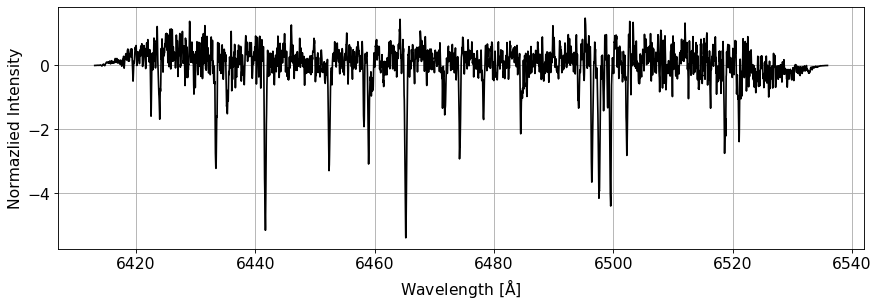

In [4]:
import copy as cp
import matplotlib.pyplot as plt

# Choose a specifiec observation
spec = cp.deepcopy(obs_list.spec_list[5])

# Remove cosmics, NaNs and zero paddings:
spec.SpecPreProccess(Ntrim=100, CleanMargins=True, RemoveNaNs=True,
                     delta=0.5, RemCosmicNum=3, FilterLC=4, FilterHC=0.15, alpha=0.3)

# Plot the resulting spectrum
plt.rcParams.update({'font.size': 14})

# plot order 27
plt.figure(figsize=(13, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(spec.wv[20], spec.sp[20], 'k')
plt.xlabel(r'Wavelength [${\rm \AA}$]')
plt.ylabel(r'Normazlied Intensity')
plt.grid()

###### <br/> 
### Preprocess the measured spectra

Now, assuming that we are pleased by the preproccessing parameters, we will run the procedure on all the measured spectra. 

In [5]:
import numpy as np

# Keep only the required orders
selected_ords = [10+I for I in np.arange(40)]
obs_list.SelectOrders(
    selected_ords, 
    remove=False)

# Remove NaNs, trim edges, remove cosmics:
# ---------------------------------------
RemoveNaNs = True     # Remove NaN values.
CleanMargins = True   # Cut the edges of the observed spectra. Remove zero padding.
Ntrim = 100           # Number of pixels to cut from each side of the spectrum.
RemCosmicNum = 3      # Number of sigma of outlier rejection. Only points that deviate upwards are rejected.

# Interpolate the spectrum to evenly sampled bins:
# ------------------------------------------------
delta = 0.5           # 0.5 is equivalent to oversampling of fator 2.

# Interpolate the spectrum to evenly sampled bins:
# ------------------------------------------------
FilterLC = 4           # Stopband freq for low-pass filter. In units of the minimal frequency (max(w)-min(w))**(-1)
FilterHC = 0.15        # Stopband freq for the high-pass filter. In units of the Nyquist frequency.
order = 1              # The order of the Butterworth filter (integer)

# Apply cosine-bell:
# ------------------
alpha = 0.3            # Shape parameter of the Tukey window
            
obs_list.PreProccessSpectra(Ntrim=Ntrim, CleanMargins=CleanMargins, RemoveNaNs=RemoveNaNs,
                            delta=delta, RemCosmicNum=RemCosmicNum, FilterLC=FilterLC, FilterHC=FilterHC,
                            alpha=alpha, verbose=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:20<00:00,  1.71s/it]


<br/> 
### 1.3 Preparing the model spectrum
#### `Template` (class)

In order to derive the velocities, we may want to obtain a synthetic template. The next step will therefore be to obtain a PHONIEX template, set it's parameters and make it analysis-ready. The `Template`, at its core, is a `Spectrum` object (stored under the `.model` attribute) with several additional routines.

A synthetic spectrum can be easily downloaded from the PHOENIX ftp, as demonstrated below. Once downloaded, it can be downsampled with integration, broadened, and arranged to match the shape of the obserbed spectrum.

In [6]:
from sparta.UNICOR.Template import Template

# Retrieve the template.
# If the template is not located in a local directory 
# it will be downloaded from the PHOENIX FTP:
template = Template(temp=5800, 
                    log_g=3.5, 
                    metal=0.5, 
                    alpha=0.0, 
                    min_val=4650, 
                    max_val=7500,
                    air=False)

# Bin the template, to reduce computational strain:
print('Integrating.', end=' ')
template.integrate_spec(integration_ratio=3)

# Make sure that the data are evenly sampled.
# No over sampling required, so the delta=1 (because when delta<1 sp is oversampled)
print('Interpolating.', end=' ')
template.model.InterpolateSpectrum(delta=1)

# Apply rotational broadening of 6 km/s:
print('Rotating.', end=' ')
template.RotationalBroadening(vsini=6, epsilon=0.5)

# Instrumental broadening for R=53,000
print('Broadening.', end=' ')
template.GaussianBroadening(resolution=53000)

# Cut the template like the observed spectrum
print('Cutting to fit spectra.', end=' ')
template.cut_multiorder_like(obs_list.spec_list[0], margins=150)

# Filter the spectrum Just like the observations were filtered:
template.model.SpecPreProccess(Ntrim=10, CleanMargins=False, RemoveNaNs=False,
                               delta=1, RemCosmicNum=3, FilterLC=4, FilterHC=0.15, alpha=0.3)

print('Done.')

Integrating. Interpolating. Rotating. Broadening. Cutting to fit spectra. Done.


##### Let's see how the model looks against the data

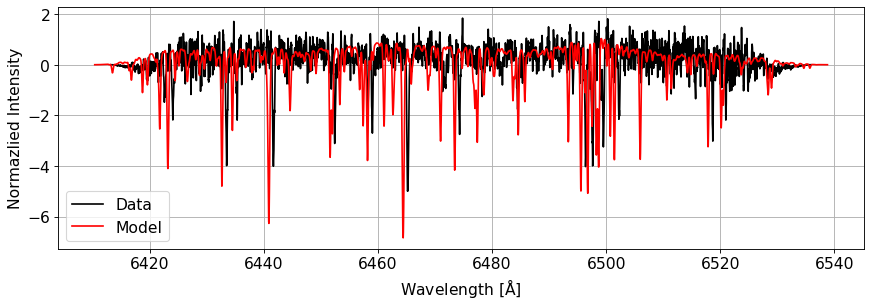

In [7]:
# Plot the resulting spectrum
plt.rcParams.update({'font.size': 14})

# plot order 27
plt.figure(figsize=(13, 4), dpi= 80, facecolor='w', edgecolor='k')
ax1 = plt.plot(obs_list.spec_list[0].wv[10], obs_list.spec_list[0].sp[10], 'k', label='Data')
ax2 = plt.plot(template.model.wv[10], template.model.sp[10], 'r', label='Model')

plt.xlabel(r'Wavelength [${\rm \AA}$]')
plt.ylabel(r'Normazlied Intensity')
plt.legend()
plt.grid()

If we are pleased with the template, we can now move on to calculate CCF and derive the velocities

<br/>

### Cross-correlating the spectra against the template

The CCF1d class holds the toolds for the cross correlation, and is called by a wrapper in the `Observations` class.

In [8]:
# Set the correlation velocity resolution and bounds.
# ---------------------------------------------------
dv = 0.05          # Assumed to be in km/s unless provided as an Astropy Unit.

# Set the velocity range for analysis:
# -----------------------------------
VelBound = [-50, 100] # Boundaries for the cross correlation.

obs_list.calc_rv_against_template(template, dv=dv, VelBound=VelBound, err_per_ord=False, combine_ccfs=True, fastccf=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:18<00:00,  1.51s/it]


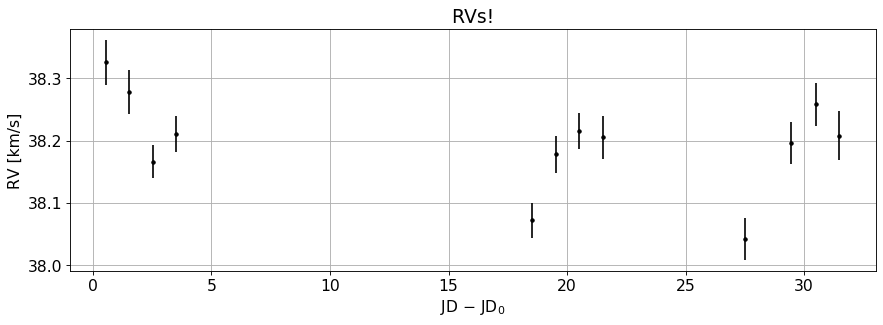

In [9]:
plt.figure(figsize=(13, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.errorbar(obs_list.time_list,
             obs_list.vels,
             yerr=obs_list.evels,
             fmt='.k')

plt.title('RVs!')
plt.xlabel(r'JD $-$ ${\rm JD}_0$')

plt.ylabel(r'RV [km/s]')
plt.grid()

#### Plot the CCF

Here's a CCF of observation #4.
The thin gray lines mark the CCFs of each order, and the thick dark line is the combined CCF. 
A red stripe is centered around the derived velocity. Its thicknes shows the velocity uncertainty.

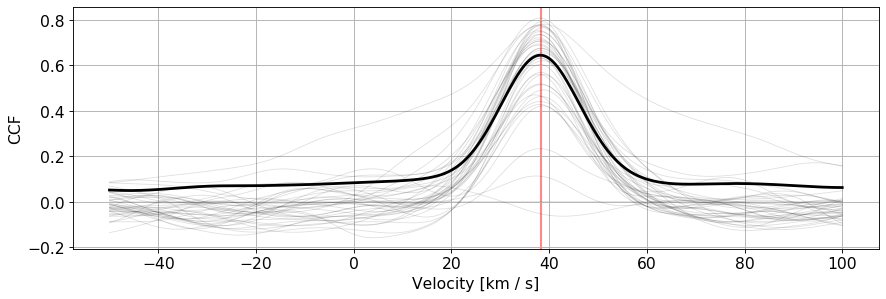

In [10]:
# %matplotlib inline
_ = obs_list.ccf_list[3].plotCCFs()